In [7]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm

In [2]:
# Set up data folder and file paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file = os.path.join(data_folder, "income_statements.json")

# Define which fields to keep
desired_fields = [
    'symbol',
    'date',
    'revenue',
    'grossProfit',
    'operatingIncome',
    'netIncome',
    'eps',
    'ebitda',
    'costOfRevenue',
    'operatingExpenses'
]

# Try loading from cached JSON if it exists
if os.path.exists(json_file):
    print("Loading data from JSON cache...")
    with open(json_file, 'r') as f:
        records = json.load(f)
else:
    # Load tickers
    df = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().tolist()

    API_KEY = 'YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6'
    records = []

    # Fetch most recent income statement per ticker
    for ticker in tickers:
        url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}'
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                row = data[0]
                row['symbol'] = ticker
                filtered_row = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered_row)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(1)  # Rate limiting

    # Save to JSON
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=2)
    print("Saved data to JSON cache.")

# Convert to DataFrame
income_df = pd.DataFrame(records)

# Show sample
print(income_df.head())


Loading data from JSON cache...
         date symbol reportedCurrency         cik fillingDate  \
0  2024-09-28   AAPL              USD  0000320193  2024-11-01   
1  2024-06-30   MSFT              USD  0000789019  2024-07-30   
2  2024-12-31   AMZN              USD  0001018724  2025-02-07   
3  2025-01-26   NVDA              USD  0001045810  2025-02-26   
4  2024-12-31  GOOGL              USD  0001652044  2025-02-05   

          acceptedDate calendarYear period       revenue  costOfRevenue  ...  \
0  2024-11-01 06:01:36         2024     FY  391035000000   210352000000  ...   
1  2024-07-30 16:06:22         2024     FY  245122000000    74114000000  ...   
2  2025-02-06 18:40:29         2024     FY  637959000000   326288000000  ...   
3  2025-02-26 16:48:33         2025     FY  130497000000    32639000000  ...   
4  2025-02-04 20:41:40         2024     FY  350018000000   146306000000  ...   

   incomeBeforeTaxRatio  incomeTaxExpense     netIncome  netIncomeRatio  \
0              0.3157

In [11]:
# Paths
data_folder  = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file     = os.path.join(data_folder, "spy_tickers_sample.csv")
output_file  = os.path.join(data_folder, "income_growth.json")

# API setup
API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
BASE_URL = "https://financialmodelingprep.com/stable/income-statement-growth"

# Try loading from cache
if os.path.exists(output_file):
    print("Loading growth data from JSON cache...")
    with open(output_file, "r") as f:
        growth_records = json.load(f)

else:
    print("No cache found — fetching growth data from API...")
    # Load tickers
    df       = pd.read_csv(csv_file)
    tickers  = df['Ticker'].tolist()
    growth_records = []

    # Fetch and flatten all periods (Solution B)
    for ticker in tickers:
        url = f"{BASE_URL}?symbol={ticker}&apikey={API_KEY}"
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()

            if isinstance(data, list) and data:
                for period in data:
                    period['symbol'] = ticker
                    growth_records.append(period)
            else:
                print(f"  • no growth data for {ticker}")

        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")

        time.sleep(1)  # respect rate limits

    # Save to JSON cache
    os.makedirs(data_folder, exist_ok=True)
    with open(output_file, "w") as f:
        json.dump(growth_records, f, indent=2)
    print(f"Saved {len(growth_records)} records to JSON cache.")

# Convert to DataFrame and inspect
df_growth = pd.DataFrame(growth_records)
print("Columns in growth DataFrame:", df_growth.columns.tolist())
df_growth.shape
df_growth.head(15)

Loading growth data from JSON cache...
Columns in growth DataFrame: ['symbol', 'date', 'fiscalYear', 'period', 'reportedCurrency', 'growthRevenue', 'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio', 'growthResearchAndDevelopmentExpenses', 'growthGeneralAndAdministrativeExpenses', 'growthSellingAndMarketingExpenses', 'growthOtherExpenses', 'growthOperatingExpenses', 'growthCostAndExpenses', 'growthInterestIncome', 'growthInterestExpense', 'growthDepreciationAndAmortization', 'growthEBITDA', 'growthOperatingIncome', 'growthIncomeBeforeTax', 'growthIncomeTaxExpense', 'growthNetIncome', 'growthEPS', 'growthEPSDiluted', 'growthWeightedAverageShsOut', 'growthWeightedAverageShsOutDil', 'growthEBIT', 'growthNonOperatingIncomeExcludingInterest', 'growthNetInterestIncome', 'growthTotalOtherIncomeExpensesNet', 'growthNetIncomeFromContinuingOperations', 'growthOtherAdjustmentsToNetIncome', 'growthNetIncomeDeductions']


,symbol,date,fiscalYear,period,reportedCurrency,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthResearchAndDevelopmentExpenses,...,growthEPSDiluted,growthWeightedAverageShsOut,growthWeightedAverageShsOutDil,growthEBIT,growthNonOperatingIncomeExcludingInterest,growthNetInterestIncome,growthTotalOtherIncomeExpensesNet,growthNetIncomeFromContinuingOperations,growthOtherAdjustmentsToNetIncome,growthNetIncomeDeductions
0,AAPL,2024-09-28,2024,FY,USD,0.020220,-0.017676,0.068195,0.047024,0.048638,...,-0.008157,-0.025435,-0.025578,0.077996,0.000000,1.000000,1.476106,-0.033600,0.0,0.0
1,MSFT,2024-06-30,2024,FY,USD,0.156700,0.125275,0.170871,0.012251,0.085126,...,0.219008,-0.002015,-0.000401,0.213006,0.532293,-0.783626,-3.088832,0.218004,0.0,0.0
2,AMZN,2024-12-31,2024,FY,USD,0.109909,0.070713,0.154140,0.039851,0.034127,...,0.906897,0.016401,0.021826,0.743293,0.375611,10.746781,-0.970213,0.947346,0.0,0.0
3,NVDA,2025-01-26,2025,FY,USD,1.142034,0.963721,1.208934,0.031232,0.488646,...,1.470588,-0.005468,-0.005453,1.473162,-1.556664,1.527094,2.041371,1.448925,0.0,0.0
4,GOOGL,2024-12-31,2024,FY,USD,0.138662,0.097306,0.170342,0.027821,0.085830,...,0.386207,-0.024624,-0.021616,0.395908,-3.441686,0.184706,4.214185,0.356704,0.0,0.0
5,META,2024-12-31,2024,FY,USD,0.219411,0.161871,0.233122,0.011244,0.140062,...,0.604573,-0.015540,-0.005706,0.490955,-0.779163,0.510478,0.895126,0.594966,0.0,0.0
6,TSLA,2024-12-31,2024,FY,USD,0.009476,0.014245,-0.011891,-0.021166,0.143865,...,-0.525581,0.012287,0.009182,-0.077895,-0.828756,0.339560,0.768946,-0.522305,0.0,0.0
7,BRK-B,2024-12-31,2024,FY,USD,0.019071,-0.019145,-0.036848,-0.054872,0.000000,...,-0.067766,-0.007703,-0.007703,-0.076640,-0.009318,0.544931,-0.975406,-0.078088,0.0,0.0
8,LLY,2024-12-31,2024,FY,USD,0.319967,0.188656,0.354357,0.026054,0.180085,...,1.018966,-0.003223,0.000858,0.911938,0.230083,-0.938521,-0.278588,1.020838,0.0,0.0
9,AVGO,2024-11-03,2024,FY,USD,0.439850,0.713092,0.316687,-0.085539,0.772321,...,-0.627273,0.114217,0.118970,-0.170465,0.207031,-2.212511,-2.195495,-0.561994,0.0,0.0


In [9]:
# Define paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
tickers_csv_path = os.path.join(data_folder, "spy_tickers_sample.csv")
output_json_path = os.path.join(data_folder, "ratios.json")

# Try loading from cache
if os.path.exists(output_json_path):
    print("Loading ratios from JSON cache...")
    with open(output_json_path, "r") as f:
        all_ratios = json.load(f)
else:
    print("No cache found — fetching ratios from API...")
    tickers_df = pd.read_csv(tickers_csv_path)
    tickers = tickers_df['Ticker'].dropna().unique().tolist()

    api_key = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    base_url = "https://financialmodelingprep.com/api/v3/ratios/{}?limit=1&apikey={}"

    all_ratios = []

    for ticker in tickers:
        try:
            url = base_url.format(ticker, api_key)
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                all_ratios.append(data[0])
            time.sleep(1)
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")

    # Save to cache
    with open(output_json_path, "w") as f:
        json.dump(all_ratios, f, indent=2)
    print(f"Saved {len(all_ratios)} records to JSON cache.")

# Convert to DataFrame
df_ratios = pd.DataFrame(all_ratios)
print(df_ratios.head(9))


Loading ratios from JSON cache...
  symbol        date calendarYear period  currentRatio  quickRatio  cashRatio  \
0   AAPL  2024-09-28         2024     FY      0.867313    0.826007   0.169753   
1   MSFT  2025-06-30         2025     FY      1.353446    1.346804   0.214151   
2   AMZN  2024-12-31         2024     FY      1.063735    0.873054   0.439049   
3   NVDA  2025-01-26         2025     FY      4.439851    3.881310   0.475924   
4  GOOGL  2024-12-31         2024     FY      1.836931    1.836931   0.263302   
5   META  2024-12-31         2024     FY      2.977884    2.977884   1.306376   
6   TSLA  2024-12-31         2024     FY      2.024912    1.607959   0.559974   
7  BRK-B  2024-12-31         2024     FY      5.941609    5.613232   0.652829   
8    LLY  2024-12-31         2024     FY      1.153757    0.886311   0.115179   

   daysOfSalesOutstanding  daysOfInventoryOutstanding  operatingCycle  ...  \
0               61.832560                   12.642571       74.475130  ...   

In [5]:


# 1. Set up paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file    = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file   = os.path.join(data_folder, "company_info.json")

# 2. Define the fields you want to keep
desired_fields = [
    "symbol", "companyName", "marketCap", "sector", "industry", "beta",
    "price", "lastAnnualDividend", "volume", "exchange", "exchangeShortName",
    "country", "isEtf", "isFund"
]

# 3. Load or fetch company info
records = []

if os.path.exists(json_file):
    print("Loading company info from JSON cache...")
    with open(json_file, "r") as f:
        records = json.load(f)

else:
    print("No cache found — fetching company info from API...")
    df      = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().unique().tolist()
    print(f"Found {len(tickers)} unique tickers.")

    API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    BASE_URL = "https://financialmodelingprep.com/api/v3/profile/{}?apikey={}"

    failed = []

    for i, ticker in enumerate(tickers, 1):
        url = BASE_URL.format(ticker, API_KEY)
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()
            if isinstance(data, list) and data:
                row = data[0]
                filtered = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered)
            else:
                print(f"  • No profile data for {ticker}")
                failed.append(ticker)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
            failed.append(ticker)
        time.sleep(1)

    os.makedirs(data_folder, exist_ok=True)
    with open(json_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} company records to cache.")
    if failed:
        print(f"{len(failed)} tickers failed to fetch: {failed[:5]}...")

# 4. Convert to DataFrame and inspect
company_df = pd.DataFrame(records)
company_df.drop_duplicates(subset="symbol", inplace=True)

print("Columns returned:", company_df.columns.tolist())
print(company_df.head(101))


Loading company info from JSON cache...
Columns returned: ['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta', 'price', 'lastAnnualDividend', 'volume', 'exchange', 'exchangeShortName', 'country', 'isEtf', 'isFund']
   symbol                   companyName marketCap                  sector  \
0    AAPL                    Apple Inc.      None              Technology   
1    MSFT         Microsoft Corporation      None              Technology   
2    AMZN              Amazon.com, Inc.      None       Consumer Cyclical   
3    NVDA            NVIDIA Corporation      None              Technology   
4   GOOGL                 Alphabet Inc.      None  Communication Services   
..    ...                           ...       ...                     ...   
95     WM        Waste Management, Inc.      None             Industrials   
96    PSX                   Phillips 66      None                  Energy   
97      D         Dominion Energy, Inc.      None               Utilities   

In [20]:
# 1. Convert columns to numeric
df_ratios['priceEarningsRatio'] = pd.to_numeric(df_ratios['priceEarningsRatio'], errors='coerce')
df_growth['growthEPSDiluted']   = pd.to_numeric(df_growth['growthEPSDiluted'], errors='coerce')

# 2. Merge on ticker
merged_df = pd.merge(
    df_ratios[['symbol', 'priceEarningsRatio']],
    df_growth[['symbol', 'growthEPSDiluted']],
    on='symbol',
    how='inner'
)

# 3. Drop rows with missing values
reg_df = merged_df.dropna(subset=['priceEarningsRatio', 'growthEPSDiluted']).copy()

# 4. Filter out non-positive EPS growth
reg_df = reg_df[reg_df['growthEPSDiluted'] > 0]

# 5. Filter out non-positive P/E ratios (to avoid log issues)
reg_df = reg_df[reg_df['priceEarningsRatio'] > 0]

# 6. Filter out non-positive EPS growth
reg_df = reg_df[reg_df['growthEPSDiluted'] > 0]

# 7. Cap EPS growth at 500% (5.0 in your units)
reg_df = reg_df[reg_df['growthEPSDiluted'] <= .3]


# 8. Log-transform the P/E ratio
reg_df['ln_PE'] = np.log(reg_df['priceEarningsRatio'])

# 9. Setup regression
X = sm.add_constant(reg_df['growthEPSDiluted'])
y = reg_df['ln_PE']

model = sm.OLS(y, X).fit()

# 8. Print results
print(model.summary())

print("""
📊 Interpretation:
The regression explains virtually none of the variation in ln(P/E), with an R² near zero and an adjusted R² slightly negative. The coefficient on EPS growth is statistically insignificant,
even after filtering out negative growth values. While the log transformation of P/E helps reduce skew and allows for percentage-based interpretation, the model still assumes a linear relationship
between ln(P/E) and EPS growth—and this assumption appears unsupported by the data. The intercept is always significant when the dependent variable has low variance and the independent variable explains nothing.
""")


                            OLS Regression Results                            
Dep. Variable:                  ln_PE   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     6.447
Date:                Mon, 11 Aug 2025   Prob (F-statistic):             0.0157
Time:                        09:50:30   Log-Likelihood:                -20.724
No. Observations:                  37   AIC:                             45.45
Df Residuals:                      35   BIC:                             48.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.9036      0.147  

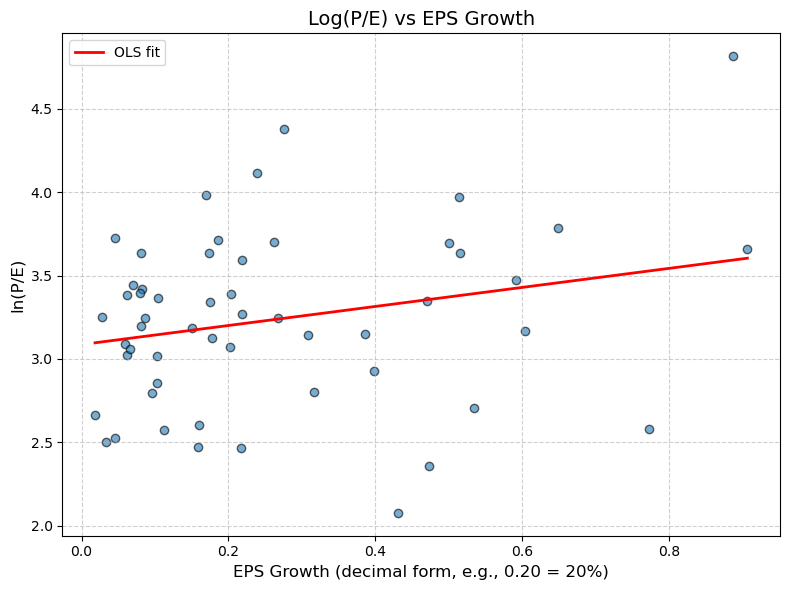

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(reg_df['growthEPSDiluted'], reg_df['ln_PE'], alpha=0.6, edgecolors='k')

# Regression line
x_vals = np.linspace(reg_df['growthEPSDiluted'].min(), reg_df['growthEPSDiluted'].max(), 100)
y_vals = model.params['const'] + model.params['growthEPSDiluted'] * x_vals
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='OLS fit')

# Labels & title
plt.xlabel("EPS Growth (decimal form, e.g., 0.20 = 20%)", fontsize=12)
plt.ylabel("ln(P/E)", fontsize=12)
plt.title("Log(P/E) vs EPS Growth", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
